# Трассировка лучей


## Подключаем библиотеки и описываем вспомогательные функции

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time

pi = np.arcsin(1)*2
eps = 2**(-10)
tiny_eps = 2**(-15)
min_significance = 0.01

class empty():
    def __init__(self):
        return None
    
class endles_none:
    def __init__(self, n):
        self.n = n
        return None
    def __iter__(self):
        return endles_none(self.n)
    def __next__(self):
        if self.n <= 0:
            raise StopIteration
        else:
            self.n -= 1
        return None
    
def none_func(n):
    def function(*args, **kwargs):
        if n > 1:
            return endles_none(n)
        elif n == 1:
            return None
        else:
            raise ValueError
    return function

def const_func(const):
    def function(*args, **kwargs):
        return const
    return function

def normalize(x):
    x /= np.linalg.norm(x)
    return x

def smooth_max(x, y, alpha):
    return (x*np.exp(alpha*x) + y*np.exp(alpha*y))/(np.exp(alpha*x) + np.exp(alpha*y))

def V3_gradient(func, point):
    x = np.array([1.,0,0])
    y = np.array([0,1.,0])
    z = np.array([0,0,1.])
    return np.array([(func(point+eps*x) - func(point-eps*x))/(2*eps),
                     (func(point+eps*y) - func(point-eps*y))/(2*eps),
                     (func(point+eps*z) - func(point-eps*z))/(2*eps)])
    

## Алгоритмы отрисовки и трассировки

In [2]:
def render_image (camera, scene, screen, *, status = 5, depth=5):
    w = screen.w
    h = screen.h
    
    image = np.zeros((h, w, 3))
    
    # ----- status output -----
    procents = 0
    if 0 < status <= 100:
        print(0,'%')
        start_t = time.time()
        last_t = start_t
        
    for i in range(h):
        for k in range(w):
            image[i][k] = camera(i,k, trace_ray, scene, depth)
        
        # ----- status output -----
        if 0 < status <= 100:
            if procents < ((i/h)*100) // status:
                tmp = time.time()
                #print(i/h*100,'% dt -', tmp - last_t)
                print("%.2f%s %.3f %s" % (i/h*100, "%", tmp - last_t, "seconds"))
                last_t = tmp
                procents = ((i/h)*100) // status
    # ----- status output -----
    if 0 < status <= 100:
        end_t = time.time()
        print("%s %.3f %s" % ("100%", end_t - start_t, "seconds"))
    
    return image

def trace_ray (scene, start, ray, depth=5, significance=1, weight=1):
    if (depth <= 0) or (weight < min_significance):
        return scene.ambience_light

    light = np.array([-12.0, 8, -7.0])
    
    color = np.ones((3))
    alpha = 0.4
    normal, dist, obj = scene.get_normal(start, ray)
    fog, fog_color = scene.fogg(start, ray, dist)
    if normal is not None:
        ans = np.zeros(3)
        point = start + ray*dist
        color = obj.get_color(point)
        mirror = obj.get_mirror(point)
        diffuse = obj.get_diffuse(point)
            
        tmp = np.sum(normalize(light-point) * normal)
        if tmp < 0:
            tmp *= -1
        _, light_dist, _ = scene.get_normal(point + normalize(light-point)*eps, normalize(light-point))
        if light_dist >= np.linalg.norm(light-point):
            light_fog, _ = scene.fogg(point, normalize(light-point), np.linalg.norm(light-point))
            ans += color * tmp * diffuse * (1-light_fog)
            specular = obj.get_specular(normalize(light-point), ray, normal)
            ans += specular * RGB(1,1,1,1)*(1-light_fog)

        if mirror > 0:
            ray -= 2*normal*np.sum(normal*ray)
            ray = normalize(ray)
            ans += mirror * trace_ray(scene, point + eps*ray, ray, depth-1, 1, weight*mirror*(1-fog))

    else:
        ans = scene.distant_color(start, ray)
    return np.minimum(fog*fog_color + (1-fog)*ans, RGB(1,1,1,1))

## Материалы

In [3]:
def RGB(R, G, B, base=255):
    return np.array([R/base, G/base, B/base])

#Cook-Torrance
def G(L, V, N, H):
    ans = min(np.sum(N*V), np.sum(N*L))
    ans = 2*ans*np.sum(N*H)/np.sum(H*V)
    return min(1, ans)

def D(N, H, m):
    cos_2 = np.sum(N*H)**2
    ans = np.exp(-(1-cos_2)/(m*m*cos_2))
    return ans/((2*m*(np.sum(N*H)**2))**2)

def F(f0, cos_):
    return f0 + (1-f0)*((1-cos_)**5)

# m - степень шероховатости
# eta - коэфицент преломления
def create_Cook_Torrance_function(m, eta):
    f0 = ((eta-1)/(eta+1))**2
    def specular_func(light, ray, normal):
        H = normalize(light - ray)
        numerator = F(f0, np.sum(-ray*normal))*D(normal, H, m)*G(light, -ray, normal, H)
        denominator = 4 * np.sum(normal*light) * np.sum(-ray*normal)
        return numerator/denominator
    return specular_func

## Описание объектов сцены

In [4]:
class render_object:
    def __init__(self, *args, **kwargs):
        if 'normal' in kwargs.keys():
            self.get_normal = kwargs['normal']
        if 'color' in kwargs.keys():
            self.get_color = kwargs['color']
        if 'specular' in kwargs.keys():
            self.get_specular = kwargs['specular']
        if 'diffuse' in kwargs.keys():
            self.get_diffuse = kwargs['diffuse']
        if 'mirror' in kwargs.keys():
            self.get_mirror = kwargs['mirror']
        return None

class scene:
    def __init__(self, render_objects, distant_color_func, ambience_color=np.zeros(3), fogg=const_func((0,RGB(0,0,0)))):
        self.objects = render_objects
        self.ambience_light = ambience_color
        self.distant_color = distant_color_func
        self.fogg = fogg
        return None
    
    def get_normal(self, start, ray):
        normal = None
        distance = np.inf
        curent_obj = None
        for obj in self.objects:
            tmp_normal, tmp_distance = obj.get_normal(start, ray, distance)
            if tmp_distance < distance:
                distance = tmp_distance
                normal = tmp_normal
                curent_obj = obj
        return normal, distance, curent_obj

def sphere(Position, R):
    def normal(start, ray, *args):
        a = np.dot(ray, ray)
        PS = start - Position
        b = 2 * np.dot(ray, PS)
        c = np.dot(PS, PS) - R * R
        disc = b * b - 4 * a * c
        if disc > 0:
            distSqrt = np.sqrt(disc)
            q = (-b - distSqrt) / 2.0 if b < 0 else (-b + distSqrt) / 2.0
            t0 = q / a
            t1 = c / q
            t0, t1 = min(t0, t1), max(t0, t1)
            if t1 >= 0:
                if t0 < 0:
                    return normalize(start + ray*t1 - Position), t1
                else:
                    return normalize(start + ray*t0 - Position), t0
        return None, np.inf
    return normal

def plane(Position, Direction):
    Direction = normalize(Direction)
    def normal(start, ray, *args):
        if np.sum((Position - start) * Direction) * np.sum(ray * Direction) <= 0:
            return None, np.inf
        else:
            return Direction, np.sum((Position - start) * Direction)/np.sum(ray * Direction)
    return normal

### Описание SDF с потдержкой CSG и преобразования SDF в объкты

In [5]:
class SDF_function:
    def __init__(self, func, gradient=None):
        self.distance = func
        if gradient is not None:
            def grad(*args, **kwargs):
                return gradient(func, *args, **kwargs)
            self.gradient = grad
        return None
    
    def add_gradient(self, gradient=None):
        def grad(*args, **kwargs):
            return gradient(self.distance, *args, **kwargs)
        self.gradient = grad
        return self
    
    def __call__(self, *args, **kwargs):
        return self.distance(*args, **kwargs)
    
    def __add__(self, other):
        def func(*args, **kwargs):
            return min(self.distance(*args, **kwargs), other.distance(*args, **kwargs))
        return SDF_function(func)
    
    def __mul__(self, other):
        def func(*args, **kwargs):
            return max(self.distance(*args, **kwargs), other.distance(*args, **kwargs))
        return SDF_function(func)
    
    def __sub__(self, other):
        def func(*args, **kwargs):
            return max(self.distance(*args, **kwargs), -other.distance(*args, **kwargs))
        return SDF_function(func)
    
    def __neg__(self):
        def func(*args, **kwargs):
            return -self.distance(*args, **kwargs)
        return SDF_function(func)
    
    def smooth(self, other, alpha=0):
        def func(*args, **kwargs):
            return smooth_max(self.distance(*args, **kwargs), other.distance(*args, **kwargs), alpha)
        return SDF_function(func)
    
def smooth_SDF(funcs, alpha, **kwargs):
    def func(*args, **kwargs):
        numerator = 0
        denominator = 0
        for f in funcs:
            x = f(*args, **kwargs)
            numerator += x*np.exp(alpha*x)
            denominator += np.exp(alpha*x)
        return numerator/denominator
    return SDF_function(func, **kwargs)

def object_from_SDF(sdf, *args, delta=0.90, **kwargs):
    def normal(start, ray, best=np.inf):
        point = np.copy(start)
        tmp = abs(sdf(point))
        if (tmp > best):
            return None, np.inf
        prev = 0
        while (tmp < 1/tiny_eps) and (np.sum((point - start)*ray) < best):
            point += ray*delta*tmp
            prev = tmp
            tmp = abs(sdf(point))
            if (tmp <= tiny_eps) and (tmp <= prev):
                if (np.sum((point - start)*ray) > 0):
                    return normalize(sdf.gradient(point)), np.sum((point - start)*ray)
                else:
                    break
        return None, np.inf
    return render_object(*args, normal=normal, **kwargs)

## Задание сцены

In [94]:
'''
    ^ y
    |  
    | 
    |
  :)o--------> x
   /
  /
 /
L z
'''
def S1(x):
    return np.linalg.norm(x-np.array([18,3,12])) - 10
def notS3(x):
    return -np.linalg.norm(x-np.array([12,8,10])) + 3
def P1(x):
    nn = normalize(np.array([0,-1.,0]))
    return np.sum((x-np.array([0,0,0]))*nn)
def P2(x):
    nn = normalize(np.array([0.,0,-1]))
    return np.sum((x-np.array([0,0,4]))*nn)
def notP2(x):
    nn = normalize(np.array([0.,0,1]))
    return np.sum((x-np.array([0,0,4]))*nn)
def S2(x):
    return np.linalg.norm(x-np.array([18,3,-0.5])) - 7.5
def notS4(x):
    return -np.linalg.norm(x-np.array([14,7,-1])) + 2.25

'''
def S4(x):'''

plastic_spec = create_Cook_Torrance_function(0.4, 4)
metal_spec = create_Cook_Torrance_function(0.07, 10)
plane_spec = create_Cook_Torrance_function(0.2, 1.25)

def some_color(point):
    p = point - np.array([13,5,9])
    return RGB(255, 201, 242)*np.cos(0.5*p) + RGB(200, 231, 255)*(1 - np.cos(0.5*p))

objs = np.array([
    #render_object(normal=sphere(np.array([11,2.5,-7]), 2.5), mirror=const_func(0.7), color=const_func(RGB(1,1,0,1)), diffuse=const_func(0.3),specular=metal_spec),
    #render_object(normal=sphere(np.array([13,5,9]), 5), mirror=const_func(0.1), color=const_func(RGB(200, 231, 255)), diffuse=const_func(0.9), specular=plastic_spec),
    render_object(normal=sphere(np.array([35,40,-30]), 40), mirror=const_func(0.95), color=const_func(RGB(0,0,0,2)), diffuse=const_func(0.05),specular=metal_spec),
    #render_object(normal=sphere(np.array([13,5.75, 4]), 4.5), mirror=const_func(0.7), color=const_func(RGB(2,1,2,2)), diffuse=const_func(0.3),specular=metal_spec),
    #render_object(normal=sphere(np.array([13,-1,-1]), 4.5), mirror=const_func(0.7), color=const_func(RGB(2,1,2,2)), diffuse=const_func(0.3),specular=metal_spec),
    render_object(normal=plane(np.array([0,0,0]), np.array([0.0,1.0,0.0])), mirror=const_func(0.25), color=const_func(np.array([1,1,1])), diffuse=const_func(0.75), specular=plane_spec),
    #object_from_SDF(SDF_function(lambda x: np.linalg.norm(x-np.array([15,2.5,-5])) - 2.5, V3_gradient)),
    #object_from_SDF(SDF_function(lambda x: np.linalg.norm(x-np.array([13,5,6])) - 5, V3_gradient)),
    #object_from_SDF(SDF_function(lambda x: np.linalg.norm(x-np.array([17,5,-1])) - 5, V3_gradient)),
    #object_from_SDF(smooth_SDF([S1,S2,S3], -1, gradient = V3_gradient)),
    #object_from_SDF(P1.add_gradient(V3_gradient), mirror=const_func(0), color=const_func(RGB(200, 231, 255)), diffuse=const_func(1), specular=plastic_spec),
    #object_from_SDF((smooth_SDF([S1,S2,S3], -1) - S4).add_gradient(V3_gradient), mirror=const_func(0.1), color=const_func(RGB(200, 231, 255)), diffuse=const_func(1), specular=plastic_spec),
    object_from_SDF((smooth_SDF([S1,P1,P2,notS3], 1.1)).add_gradient(V3_gradient), delta=0.75, mirror=const_func(0.7), color=const_func(RGB(1,1,0,1)), diffuse=const_func(0.3),specular=metal_spec),
    object_from_SDF((smooth_SDF([S2,P1,notP2,notS4], 1.2)).add_gradient(V3_gradient), delta=0.75, mirror=const_func(0.7), color=const_func(RGB(1,1,0,1)), diffuse=const_func(0.3),specular=metal_spec),
    #object_from_SDF(((S5 - S6).smooth(S7, 1.25)).add_gradient(V3_gradient), mirror=const_func(0), color=const_func(RGB(200, 231, 255)), diffuse=const_func(1), specular=plastic_spec)
])

def ambient_collor(start, ray):
    high = (np.sum(ray*normalize(np.array([0.1,1,-0.3]))) + 1)/2
    return high*RGB(117, 187, 253) + (1-high)*RGB(243, 148, 98)

def simple_fogg(start, ray, dist):
    if dist == np.inf:
        return 1, ambient_collor(start, ray)
    return (1 - np.exp(-dist/20)), ambient_collor(start, ray)

# F(z)=exp(-g(z)) - видимость в точке
# g(z) - затуманеность точки
# I = Integral g(z(l))dl from start to end - затуманеность пути
# 1 - exp(-I) - вклад тумана
# G = Integral g(z)dz

fog_height = 7
fog_intensity = 0.01

def fog_g(z):
    return np.maximum(0, fog_height-z)*fog_intensity

def fog_G(z):
    if z <= fog_height:
        return -((z-fog_height)**2)*fog_intensity/2
    else:
        return 0

def I(start, ray, dist):
    fog_direction = np.array([0,1,0])
    cos_ = np.sum(fog_direction*ray)
    if cos_ == 0:
        if dist != np.inf:
            return dist*fog_g(start[1])
        elif fog_g(start[1]) > 0:
            return np.inf
        else:
            return 0
    else:
        return (fog_G(start[1] + dist*cos_) - fog_G(start[1]))/cos_

def layered_fogg(start, ray, dist):
    return (1 - np.exp(-I(start, ray, dist))), RGB(50, 50, 130)#RGB(189, 164, 164)

my_scene = scene(objs, ambient_collor, RGB(17, 15, 11), layered_fogg) #np.array([0.49,0.72,0.97])

## Описание камеры

In [84]:
class axis:
    def __init__(self, position, x_direction, y_direction, z_direction):
        self.position = position
        self.dx = normalize(x_direction)
        self.dy = normalize(y_direction)
        self.dz = normalize(z_direction)
        self.forward = self.dx;
        self.back = -self.dx;
        self.up = self.dy;
        self.down = -self.dy;
        self.right = self.dz;
        self.left = -self.dz;
        return None

class camera:
    def __init__(self, axis, view_tangent, focus_distance, aperture = np.array([[[0.,0,0],1]])):
        self.axis = axis
        self.view_tangent = view_tangent
        self.focal_length = focus_distance
        self.aperture = aperture
        return None
    
    def __call__(self, i,k, trace_ray, scene, depth):
        pixel_pos = self.axis.forward + self.pix_size*(self.axis.right*(k - self.w/2) + self.axis.up*(self.h/2 - i))
        ray = normalize(pixel_pos)
        rays = self.ray_array(self.axis.position, ray)
        pix_color = RGB(0,0,0)
        for ray in rays:
            pix_color += ray[2]*trace_ray(scene, ray[0], ray[1], depth)
        return pix_color

    def insert_matrix(self, matrix):
        self.pix_size = 2*self.view_tangent/np.linalg.norm([matrix.h,matrix.w])
        self.w = matrix.w
        self.h = matrix.h

    def ray_array(self, start, ray):
        principal = ray*self.focal_length/np.sum(ray*self.axis.forward)
        ans = np.array([np.array([start + point[0], normalize(principal - point[0]), point[1]]) for point in self.aperture])
        #ans = np.array([[start, ray, 1]])
        return ans

def creat_ring_aperture(dot_count, radius):
    return np.array([np.array([radius*RGB(0,np.sin(2*pi*i/dot_count),np.cos(2*pi*i/dot_count),1), 1/dot_count]) for i in range(dot_count)])


# диафрагма камеры представляется как набор точек с весом (доля света проходящая через эту точку)
#camera_aperture = np.array([[[0.,1,0],0.25],[[0.,-1,0],0.25],[[0.,0,1],0.25],[[0.,0,-1],0.25]])
camera_aperture = creat_ring_aperture(25, 1)

camera_screen = empty();
#camera_screen.w = 1920; camera_screen.h = 1080
#camera_screen.w = 960; camera_screen.h = 540
#camera_screen.w = 600; camera_screen.h = 360
camera_screen.w = 300; camera_screen.h = 179
camera_screen.w = 200; camera_screen.h = 120
#camera_screen.w = 120; camera_screen.h = 70
#camera_screen.w = 90; camera_screen.h = 53
#camera_screen.w = 60; camera_screen.h = 35

camera_axis = axis(np.array([-3.0, 5.1, 2.5]), np.array([1.0, 0, 0]), np.array([0, 1.0, 0]), np.array([0, 0, 1.0]))
my_camera = camera(camera_axis, 1.6, 40.0)
my_camera.insert_matrix(camera_screen)

## Просчитываем сцену

In [8]:
# оцениваем время расчётов
def approximate_time(camera, scene, camera_screen, depth):
    tg = camera_screen.w/camera_screen.h
    little_matrix = empty(); little_matrix.w = int(tg*20+1); little_matrix.h = 20
    camera.insert_matrix(little_matrix)
    start_t = time.time()
    render_image(camera, scene, little_matrix, status = 100, depth=depth)  
    end_t = time.time()
    camera.insert_matrix(camera_screen)
    apr_time = (end_t - start_t)*(camera_screen.w/little_matrix.w)*(camera_screen.h/little_matrix.h)
    print("approximate %.3f seconds" % apr_time)

0 %


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:50: RuntimeWarning: overflow encountered in double_scalars


100% 8.191 seconds
approximate 289.112 seconds
0 %
5.00% 6.600 seconds
10.00% 8.090 seconds
15.00% 7.863 seconds
20.00% 10.174 seconds
25.00% 10.281 seconds
30.00% 15.530 seconds
35.00% 21.213 seconds
40.00% 25.448 seconds
45.00% 16.255 seconds
50.00% 14.668 seconds
55.00% 14.215 seconds
60.00% 12.348 seconds
65.00% 13.261 seconds
70.00% 14.979 seconds
75.00% 18.958 seconds
80.00% 18.119 seconds
85.00% 16.371 seconds
90.00% 16.407 seconds
95.00% 17.433 seconds
100% 291.868 seconds


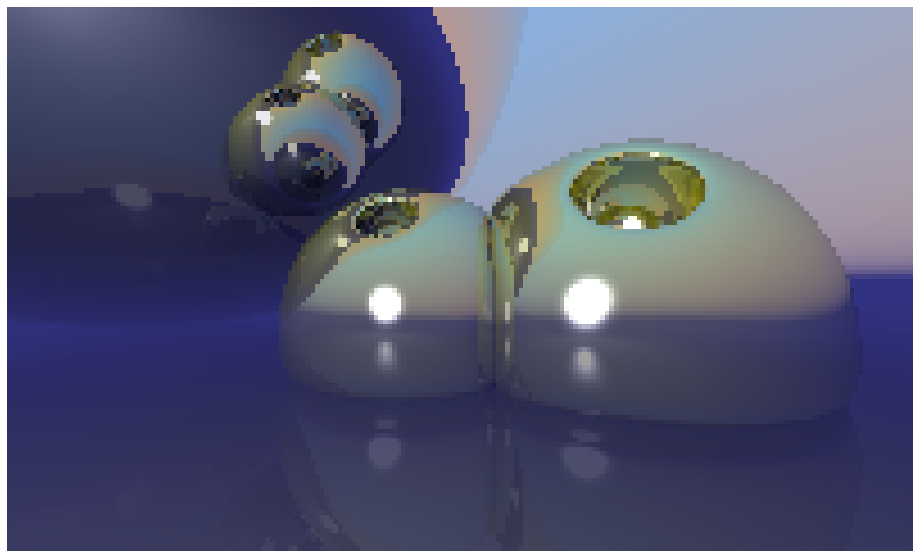

In [95]:
approximate_time(my_camera, my_scene, camera_screen, depth = 16)  
img = render_image(my_camera, my_scene, camera_screen, depth = 16)

#plt.imsave('tmp.png', img)
plt.figure(figsize=(20,10))
plt.axis(False)
plt.imshow(img)

Mounted at /content/drive
0 %
1.02% 11.882 seconds
2.04% 10.825 seconds
3.06% 10.878 seconds
4.07% 11.076 seconds
5.00% 10.054 seconds
6.02% 11.297 seconds
7.04% 11.334 seconds
8.06% 11.667 seconds
9.07% 11.739 seconds
10.00% 10.829 seconds
11.02% 11.927 seconds
12.04% 11.946 seconds
13.06% 11.848 seconds
14.07% 11.621 seconds
15.00% 10.286 seconds
16.02% 11.208 seconds
17.04% 11.401 seconds
18.06% 11.627 seconds
19.07% 11.842 seconds
20.00% 10.972 seconds
21.02% 12.170 seconds
22.04% 13.042 seconds
23.06% 12.786 seconds
24.07% 12.737 seconds
25.00% 11.221 seconds
26.02% 11.600 seconds
27.04% 12.140 seconds
28.06% 12.679 seconds
29.07% 12.954 seconds
30.00% 12.275 seconds
31.02% 14.525 seconds
32.04% 15.100 seconds
33.06% 15.314 seconds
34.07% 15.913 seconds
35.00% 14.902 seconds
36.02% 16.945 seconds
37.04% 16.995 seconds
38.06% 17.225 seconds
39.07% 17.405 seconds
40.00% 15.954 seconds
41.02% 17.220 seconds
42.04% 16.995 seconds
43.06% 16.853 seconds
44.07% 17.032 seconds
45.00% 15.6

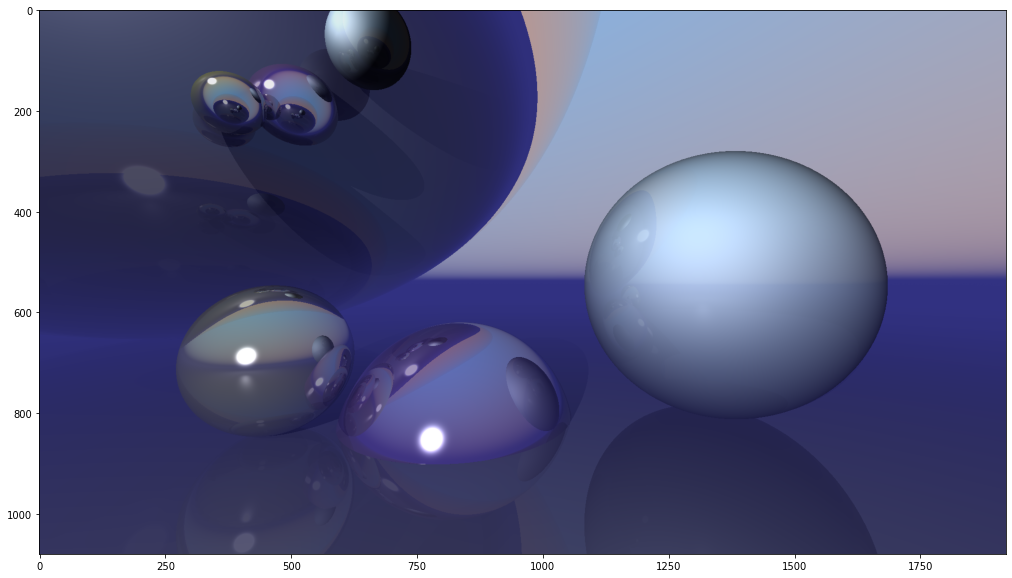

In [163]:
my_camera = empty()
my_camera.position = np.array([-2.0, 5.1, 1.5])
my_camera.orientate = np.array([0.1, 0, 0])
my_camera.dx = np.array([0.0, 0.0, 1.0])
my_camera.dy = np.array([0.0, 1.0, 0.0])

my_camera.delta = 0.0001328125
camera_screen = empty()
camera_screen.w = 1920
camera_screen.h = 1080

from google.colab import drive
drive.mount('/content/drive')

img = render_image(my_camera, my_scene, camera_screen, status = 1, depth = 16)

plt.imsave('/content/drive/My Drive/Colab Notebooks/my_image2.png', img)
drive.flush_and_unmount()
plt.figure(figsize=(20,10))
plt.imshow(img)

### Немного кода для теста

In [160]:
'''import matplotlib.gridspec as gridspec
fig2 = plt.figure(constrained_layout=True, figsize=(20,10))
spec2 = gridspec.GridSpec(nrows=1, ncols=3, figure=fig2)
f2_ax1 = fig2.add_subplot(spec2[0, 0])
f2_ax2 = fig2.add_subplot(spec2[0, 1])
f2_ax3 = fig2.add_subplot(spec2[0, 2])
f2_ax1.imshow(t_img)
f2_ax2.imshow(tmp_img)
f2_ax3.imshow(dir_img)'''

In [ ]:
_from google.colab import drive
drive.mount('/content/drive')
plt.imsave('/content/drive/My Drive/Colab Notebooks/tmp.png', img)
drive.flush_and_unmount()

Mounted at /content/drive
